Import Libraries

In [338]:
import pandas as pd
import numpy as np
import os
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns


Currency Codes

In [339]:
country_currency_codes_table = {
    'Burundi': 'BIF',
    'Benin': 'XOF',
    'Burkina Faso': 'XOF',
    'Central African Republic': 'XAF',
    "Côte d'Ivoire": 'XOF',
    'Cameroon': 'XAF',
    'Democratic Republic of the Congo': 'CDF',
    'Republic of Congo': 'XAF',
    'Comoros': 'KMF',
    'Eritrea': 'ERN',
    'Ethiopia': 'ETB',
    'Ghana': 'GHS',
    'Guinea': 'GNF',
    'The Gambia': 'GMD',
    'Guinea-Bissau': 'XOF',
    'Liberia': 'LRD',
    'Madagascar': 'MGA',
    'Mali': 'XOF',
    'Mozambique': 'MZN',
    'Mauritania': 'MRU',
    'Malawi': 'MWK',
    'Niger': 'XOF',
    'Rwanda': 'RWF',
    'Sudan': 'SDG',
    'Senegal': 'XOF',
    'Sierra Leone': 'SLL',
    'Somalia': 'SOS',
    'Sao Tomee and Principe': 'STN',
    'Chad': 'XAF',
    'Togo': 'XOF',
    'Tanzania': 'TZS',
    'Uganda': 'UGX',
    'Zambia': 'ZMW'
}


Read Data

In [340]:
#read in stata dataset as dataframe "country_code_df"
country_code_df = pd.read_stata("codesffactors_Mar23_2019.dta") 
country_code_df.replace('--', np.nan, inplace=True) #replace all entries that are '--' with NaN data value

country_code_df.head()

,countryname,wbctry,wbcode,wbregion,wbigroup2017,wblcat2017,hipc,emu,cemac,waemu,imfcode,imfweocode,imfweoiso,imfweoctry,region
0,Aruba,Aruba,ABW,Latin America & Caribbean,High income,NaN,0,0,0,0,NaN,314.0,ABW,Aruba,LAC
1,Afghanistan,Afghanistan,AFG,South Asia,Low income,IDA,1,0,0,0,512.0,512.0,AFG,Afghanistan,SAS
2,Angola,Angola,AGO,Sub-Saharan Africa,Lower middle income,IBRD,0,0,0,0,614.0,614.0,AGO,Angola,SSA
3,Anguilla,NaN,AIA,Latin America & Caribbean,NaN,NaN,0,0,0,0,312.0,NaN,NaN,NaN,LAC
4,Albania,Albania,ALB,Europe & Central Asia,Upper middle income,IBRD,0,0,0,0,914.0,914.0,ALB,Albania,ECA


In [341]:
region_classification_ls = country_code_df['wbregion'].unique() #get a list of region classifications
income_classification_ls = country_code_df['wbigroup2017'].unique() #get a list of income classifications
income_classification_ls = [x for x in income_classification_ls if not pd.isna(x)] # remove '--' from income_classification_ls

print(f"The region classifications are: {', '.join(country for country in region_classification_ls)}")
print(f"The income classifications are: {', '.join(country for country in income_classification_ls)}")

The region classifications are: Latin America & Caribbean, South Asia, Sub-Saharan Africa, Europe & Central Asia, Middle East & North Africa, East Asia & Pacific, North America
The income classifications are: High income, Low income, Lower middle income, Upper middle income


In [342]:
ssa_hipc_countries = country_code_df[(country_code_df['hipc'] == 1) & (country_code_df['wbregion'] == 'Sub-Saharan Africa')]
ssa_hipc_countries_ls = ssa_hipc_countries['imfweoctry'].to_list()

ssa_hipc_countries_ls

['Burundi',
 'Benin',
 'Burkina Faso',
 'Central African Republic',
 "Côte d'Ivoire",
 'Cameroon',
 'Democratic Republic of the Congo',
 'Republic of Congo',
 'Comoros',
 'Eritrea',
 'Ethiopia',
 'Ghana',
 'Guinea',
 'The Gambia',
 'Guinea-Bissau',
 'Liberia',
 'Madagascar',
 'Mali',
 'Mozambique',
 'Mauritania',
 'Malawi',
 'Niger',
 'Rwanda',
 'Sudan',
 'Senegal',
 'Sierra Leone',
 'Somalia',
 'São Tomé and Príncipe',
 'Chad',
 'Togo',
 'Tanzania',
 'Uganda',
 'Zambia']

Read in IMF's Government Finance Statistics

In [343]:
master_table = {}
folder_path = "revenue-data"

# Loop that goes through all files 'file_name' in the folder 'folder_path'
for file_name in os.listdir(folder_path):
  if file_name.endswith('.xlsx') and not file_name.startswith('~$'): #check to see if is spreadsheet .xlsx format
    raw_df = pd.read_excel(folder_path+ "/" + file_name) #read in .xlsx as dataframe
    master_table[file_name[:-5]] = raw_df #store dataframe as an entry in the master_table hash table

# master_table["Central African Republic"]
for key in master_table:
  print(master_table[key])

                                           Unnamed: 0  \
0                          Detailed Revenue Breakdown   
1                                      Country: Benin   
2                Sector: Budgetary central government   
3                             Unit: Domestic currency   
4                                     Scale: Billions   
5                                                 NaN   
6                                                 NaN   
7                                             Revenue   
8                                               Taxes   
9           Taxes on income, profits, & capital gains   
10  Taxes on income, profits, & capital gains: ind...   
11  Taxes on income, profits, & capital gains: cor...   
12   Taxes on income, profits, & capital gains: other   
13                       Taxes on payroll & workforce   
14                                  Taxes on property   
15                          Taxes on goods & services   
16                  General tax

Filtering

In [344]:
#REMOVE "JUNK" ROWS AND CONVERT TO CORRECT SCALE (MILLION/BILLIONS)
for key in master_table: #loop through table (where key is the country name) (master_table[key] is the dataframe stored in the master_table indexed by key)
  scale = master_table[key].iloc[4,0] #get if values have scale of billions or millions
  
  # Drop rows 0 to 5, reformatting indexes and column headers
  master_table[key] = master_table[key].drop([0, 1, 2, 3, 4, 5]) 
  master_table[key] = master_table[key].reset_index(drop=True) 
  master_table[key].columns = master_table[key].iloc[0]
  master_table[key] = master_table[key][1:]
  master_table[key] = master_table[key].set_index(master_table[key].columns[0])
  master_table[key].columns = [int(float(col)) for col in master_table[key].columns]
  # master_table[key] = master_table[key].fillna(0)

  if scale == "Scale: Billions":
    master_table[key] = master_table[key]* (10 ** 9) #multiple every value in dataframe by 1e9 if scale is billion
  elif scale == "Scale: Millions":
    master_table[key] = master_table[key]* (10 ** 6) #multiple every value in dataframe by 1e9 if scale is billion


#FILTER OUT YEAR COLUMNS ACCOUNTING DOESNT ADD UP
#first level: make sure 'Taxes', 'Social Contributions', 'Grants, 'Other Revenue' Sums to 'Revenue'
#second level: make sure 'Taxes on income, profits, & capital gains', 'Taxes on payroll & workforce', 'Taxes on property', 'Taxes on goods & services', 'Taxes on int trade & transactions', 'Other taxes n.e.c.' sum to 'Taxes'
first_level_ls = ['Taxes', 'Social contributions', 'Grants', 'Other revenue']
second_level_ls = ['Taxes on income, profits, & capital gains', 'Taxes on payroll & workforce', 'Taxes on property', 'Taxes on goods & services', 'Taxes on int trade & transactions', 'Other taxes n.e.c.']
                  
for key in master_table:
  years_accounting_error_ls = []
  years_available = master_table[key].columns
  for year in years_available:
    country_year_df = master_table[key][year]
    revenue = 0 
    taxes = 0
    for category in first_level_ls:
      if category in country_year_df.index:
        revenue += country_year_df[category]
      # else: 
      #   print(category)
    for category in second_level_ls:
      if category in country_year_df.index:
        taxes += country_year_df[category]
    # if round(taxes, 0) != round(country_year_df['Taxes'], 0) or round(revenue, 0) != round(country_year_df['Revenue'], 0):
    
    margin = 0.001
    lower_bound_taxes = country_year_df['Taxes'] - country_year_df['Taxes']*margin
    upper_bound_taxes = country_year_df['Taxes'] + country_year_df['Taxes']*margin
    lower_bound_revenue = country_year_df['Revenue'] - country_year_df['Revenue']*margin
    upper_bound_revenue = country_year_df['Revenue'] + country_year_df['Revenue']*margin

    if taxes < lower_bound_taxes or taxes > upper_bound_taxes or revenue < lower_bound_revenue or revenue > upper_bound_revenue:
    
      print(f"{round(taxes, 0)}, {round(country_year_df['Taxes'], 0)}, {round(revenue, 0)}, {round(country_year_df['Revenue'], 0)}")

      years_accounting_error_ls.append(year)
  
  print(key)
  print(years_accounting_error_ls)
  master_table[key].drop(columns=years_accounting_error_ls, inplace=True)
 
    
    

#FILTER OUT COUNTRIES WITH LESS THAN 7 YEARS OF DATA
less_than_seven_years_data_countries = [] #create list to store countries with less than 7 years of historial data
for key in master_table: #iterate through master_table
  num_columns = master_table[key].shape[1] #count the number of columns (each column represents a year)
  if num_columns < 7: #if less than 7 columns/year, add to list to delete
    less_than_seven_years_data_countries.append(key)

print('remove')
for country in less_than_seven_years_data_countries:
  print(country)
  del master_table[country] #delete countries with less than 7 years from data table

Benin
[]
Senegal
[]
Côte d'Ivoire
[]
Burkina Faso
[]
Central African Republic
[]
Somalia
[]
Tanzania
[]
Democratic Republic of the Congo
[]
Rwanda
[]
Republic of Congo
[]
Sudan
[]
450175108347.0, 498921783147.0, 604225591780.0, 604225591780.0
Togo
[2016]
Mali
[]
Malawi
[]
Sao Tomee and Principe
[]
Mozambique
[]
Sierra Leone
[]
Guinea-Bissau
[]
Burundi
[]
Liberia
[]
Cameroon
[]
Madagascar
[]
remove
Benin
Somalia
Guinea-Bissau
Liberia


Convert Currency

In [345]:
print('keep')
for key in master_table:
  print(key)

#CONVERT LOCAL CURRENCY DENOMINATED VALUES TO USD
error_countries = []
for key in master_table:
  #get annual 2010-2019 USD to domestic currency exchange rate using yfinance library
  currency = country_currency_codes_table[key] #retrieve currency symbol from 'country_currency_codes_table'
  symbol = f"{currency}=X"
  try:
    data = yf.download(symbol, start="2010-01-01", end="2020-01-01", interval="1mo") #download monthly USD-Currency dataset from 2010-2020
    yearly_data_df = data['Close'].resample('YE').mean() #get the annual average exchange rate outputted as datafram
    yearly_data_table = yearly_data_df.to_dict() # Convert the yearly_data to a hash table with the date as the key
    year_to_exchange_rate_dict = {key.year: value for key, value in yearly_data_table.items()} # Convert the keys to only the year part
    print(year_to_exchange_rate_dict)

    #convert DataFrame values to USD
    for year in master_table[key].columns: #loop through columns in dataframe
      year_int = int(year)  # Convert year to integer to match the dictionary keys
      master_table[key][year] = master_table[key][year] / year_to_exchange_rate_dict[year_int] #divide each column's values by that year's exchange rate

  except Exception as e: #if errored out
    print(f"Could not fetch rate for {key} ({currency}): {e}")
    error_countries.append(key) #add country to error list
    pass
    
for country in error_countries:
  del master_table[country] #delete countries where currency conversion failed
 
for key in master_table:
  print(key)
  print(master_table[key])

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

keep
Senegal
Côte d'Ivoire
Burkina Faso
Central African Republic
Tanzania
Democratic Republic of the Congo
Rwanda
Republic of Congo
Sudan
Togo
Mali
Malawi
Sao Tomee and Principe
Mozambique
Sierra Leone
Burundi
Cameroon
Madagascar
{2010: 487.61083221435547, 2011: 460.5933329264323, 2012: 501.0466715494792, 2013: 492.91916910807294, 2014: 497.47583770751953, 2015: 594.4266713460287, 2016: 594.0358378092448, 2017: 577.82666015625, 2018: 557.75, 2019: 583.7949981689453}
{2010: 487.61083221435547, 2011: 460.5933329264323, 2012: 501.0466715494792, 2013: 492.91916910807294, 2014: 497.47583770751953, 2015: 594.4266713460287, 2016: 594.0358378092448, 2017: 577.82666015625, 2018: 557.75, 2019: 583.7949981689453}
{2010: 487.61083221435547, 2011: 460.5933329264323, 2012: 501.0466715494792, 2013: 492.91916910807294, 2014: 497.47583770751953, 2015: 594.4266713460287, 2016: 594.0358378092448, 2017: 577.82666015625, 2018: 557.75, 2019: 583.7949981689453}
{2010: 487.5991668701172, 2011: 460.5908304850


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

{2010: 1422.5833231608074, 2011: 1568.4333394368489, 2012: 1563.4083455403645, 2013: 1581.8916727701824, 2014: 1632.8416646321614, 2015: 1989.9833170572917, 2016: 2136.6749674479165, 2017: 2193.6416625976562, 2018: 2273.074991861979, 2019: 2301.0916748046875}
{2010: 886.25, 2011: 910.0, 2012: 904.5833333333334, 2013: 906.6291656494141, 2014: 907.25, 2015: 910.0, 2016: 978.4496866861979, 2017: 1457.9642842610676, 2018: 1580.0, 2019: 1630.0}
{2010: 575.0333302815756, 2011: 590.4300028483073, 2012: 599.2916666666666, 2013: 640.4175059000651, 2014: 674.0025024414062, 2015: 696.072499593099, 2016: 768.2083384195963, 2017: 827.0033365885416, 2018: 847.0541687011719, 2019: 901.6158345540365}
{2010: 487.5991668701172, 2011: 460.59083048502606, 2012: 501.04666900634766, 2013: 492.91916910807294, 2014: 497.4808349609375, 2015: 594.4341735839844, 2016: 594.0333353678385, 2017: 578.2424977620443, 2018: 556.1933390299479, 2019: 586.7139180501302}



[*********************100%%**********************]  1 of 1 completed

{2010: 2.318599979082743, 2011: 2.648924986521403, 2012: 3.52014168103536, 2013: 4.590566674868266, 2014: 5.666366696357727, 2015: 5.987816691398621, 2016: 6.130283355712891, 2017: 6.609750032424927, 2018: 25.39816665649414, 2019: 45.693160692850746}



[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed

1 Failed download:
['STN=X']: YFInvalidPeriodError("%ticker%: Period 'max' is invalid, must be one of ['1d', '5d']")
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


{2010: 487.61083221435547, 2011: 460.5933329264323, 2012: 501.0466715494792, 2013: 492.91916910807294, 2014: 497.47583770751953, 2015: 594.4266713460287, 2016: 594.0358378092448, 2017: 577.82666015625, 2018: 557.75, 2019: 583.7949981689453}
{2010: 487.61083221435547, 2011: 460.5933329264323, 2012: 501.0466715494792, 2013: 492.91916910807294, 2014: 497.47583770751953, 2015: 594.4266713460287, 2016: 594.0358378092448, 2017: 577.82666015625, 2018: 557.75, 2019: 583.7949981689453}
{2010: 148.9291674296061, 2011: 155.58916854858398, 2012: 247.6258316040039, 2013: 362.4624989827474, 2014: 410.5541687011719, 2015: 495.21583557128906, 2016: 700.3816680908203, 2017: 720.1374969482422, 2018: 704.3308308919271, 2019: 718.8183339436849}
Could not fetch rate for Sao Tomee and Principe (STN): Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'
{2010: 34.550000508626304, 2011: 28.579166730244953, 2012: 28.048333326975506, 2013: 29.664999802907307, 2014: 31.184

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


{2010: 1206.0750122070312, 2011: 1216.6916605631511, 2012: 1396.4749857584636, 2013: 1531.5916748046875, 2014: 1530.9249877929688, 2015: 1536.9166666666667, 2016: 1605.7583312988281, 2017: 1700.5, 2018: 1756.2916666666667, 2019: 1822.7166646321614}
{2010: 487.5991668701172, 2011: 460.59083048502606, 2012: 501.04666900634766, 2013: 492.91916910807294, 2014: 497.4808349609375, 2015: 594.4341735839844, 2016: 594.0333353678385, 2017: 578.2424977620443, 2018: 556.1933390299479, 2019: 586.7139180501302}
{2010: 2070.574991861979, 2011: 1995.8000183105469, 2012: 2154.4749755859375, 2013: 2174.9000040690103, 2014: 2460.4250284830728, 2015: 3095.6833699544272, 2016: 3135.3916625976562, 2017: 3076.9583333333335, 2018: 3307.1916707356772, 2019: 3290.9500080744424}
Senegal
                                                                 2010  \
nan                                                                     
Revenue                                              2867744175.10332   
Taxes     

Calculate Yearly Averages

In [346]:
data_by_year_table = {
  2010: [],
  2011: [],
  2012: [],
  2013: [],
  2014: [],
  2015: [],
  2016: [],
  2017: [],
  2018: [],
  2019: [],
} #make table that stores data by year

# master_averages_ls = [] #make master averages list as place to store averages

for key in master_table:
  years_available = master_table[key].columns
  for year in data_by_year_table:
    if year in years_available:
      data_by_year_table[year].append(master_table[key][year])

yearly_averages_ls = [] #make a list of the yearly averages
for year in data_by_year_table:
  merged_year_df = pd.concat(data_by_year_table[year], axis=1, join='outer')
  #SUM OR MEAN?
  year_average_df = merged_year_df.sum(axis=1) #get the average of all the countries' averages
  yearly_averages_ls.append(year_average_df)

 
# #Get average over decade
# #loop through table (where key is the country name) (master_table[key] is the dataframe stored in the master_table indexed by key)
# for key in master_table:
#   per_category_average = master_table[key].mean(axis=1) #get the average of each category (ignoring np.NaN values) into a list
#   # per_category_average.drop('To other government units', inplace=True) #drop 'To other government units' since there's two rows named that and will error
#   master_averages_ls.append(per_category_average) #add each country average to to the master averages list



# merged_averages_df = pd.concat(master_averages_ls, axis=1, join='outer')
# average__of_averages_df = merged_averages_df.mean(axis=1) #get the average of all the countries' averages
# average__of_averages_df

for i in range(len(yearly_averages_ls)):
  print(f"YEAR: {2010+i}")
  print(yearly_averages_ls[i])

YEAR: 2010
nan
Revenue                                                    46135090696.262459
Taxes                                                      24310248856.894337
Taxes on income, profits, & capital gains                   6283109201.590809
Taxes on income, profits, & capital gains: individuals      2493307325.573338
Taxes on income, profits, & capital gains: corporations     2114773377.788073
Taxes on income, profits, & capital gains: other             254810688.188532
Taxes on payroll & workforce                                  58219502.201636
Taxes on property                                             66431403.604901
Taxes on goods & services                                  11103540077.400969
General taxes on goods & services                           6304097265.801343
Excise taxes                                                 2084328524.40197
Taxes on int trade & transactions                           5521210711.698543
Other taxes n.e.c.                               

Calculate Percentages

In [347]:
yearly_averages_percentage_ls = []

year = 2010
for year_average_df in yearly_averages_ls:


  total_taxes = year_average_df['Taxes']
  year_average_percentage_df = year_average_df / total_taxes * 100 #take all values as a fraction of total expenditure, then convert decimal to percent, then round to two decimal places
  
  first_level = 0
  print(year)
  for category in second_level_ls:
    first_level += year_average_percentage_df[category]
  print(first_level)
  print(year_average_percentage_df['Revenue'])
  year += 1
  
  yearly_averages_percentage_ls.append(year_average_percentage_df)

for i in range(len(yearly_averages_percentage_ls)):
  print(f"YEAR: {2010+i}")
  print(yearly_averages_percentage_ls[i])

2010
99.2480358736606
189.77629956749144
2011
99.20319832867142
181.32322567185233
2012
99.35911435326378
153.5630774501148
2013
100.00000170606724
165.6573563907263
2014
99.81611666803533
145.71827280106245
2015
99.77360432033221
134.68773695620635
2016
99.70188017054137
125.67801862579306
2017
99.60431437313514
125.73483346597047
2018
99.52177979757988
130.96732981516334
2019
99.99998884078417
130.4326051357895
YEAR: 2010
nan
Revenue                                                     189.7763
Taxes                                                          100.0
Taxes on income, profits, & capital gains                  25.845516
Taxes on income, profits, & capital gains: individuals     10.256198
Taxes on income, profits, & capital gains: corporations     8.699102
Taxes on income, profits, & capital gains: other            1.048162
Taxes on payroll & workforce                                0.239485
Taxes on property                                           0.273265
Taxes on goods &

Calculate Average Across Period

In [348]:
merged_percentages_df = pd.concat(yearly_averages_percentage_ls, axis=1, join='outer')
average_df = merged_percentages_df.mean(axis=1)
rounded_average_df = average_df.apply(lambda x: round(x, 2))

rounded_average_df = rounded_average_df.to_frame()
rounded_average_df

,0
nan,
Revenue,148.35
Taxes,100.00
"Taxes on income, profits, & capital gains",30.10
"Taxes on income, profits, & capital gains: individuals",11.99
"Taxes on income, profits, & capital gains: corporations",13.23
"Taxes on income, profits, & capital gains: other",1.40
Taxes on payroll & workforce,0.42
Taxes on property,0.67
Taxes on goods & services,48.23


In [349]:
#check
first_level = 0
for category in first_level_ls:
  first_level += average_df[category]
print(first_level)

second_level = 0
for category in second_level_ls:
  second_level += average_df[category]
print(second_level)

147.47435436113508
99.62280344320712


In [350]:
rounded_by_year_average_df = merged_percentages_df.round(2)
# rounded_by_year_average_df.iloc[:, 5:]
rounded_by_year_average_df

,0,1,2,3,4,5,6,7,8,9
nan,,,,,,,,,,
Revenue,189.7763,181.32,153.563077,165.66,145.72,134.69,125.68,125.73,130.97,130.43
Taxes,100.0,100.00,100.0,100.00,100.00,100.00,100.00,100.00,100.00,100.00
"Taxes on income, profits, & capital gains",25.845516,27.98,28.667918,29.70,30.69,29.70,28.05,32.29,33.49,34.54
"Taxes on income, profits, & capital gains: individuals",10.256198,10.94,10.527234,10.29,11.65,12.23,12.48,14.10,14.37,13.05
"Taxes on income, profits, & capital gains: corporations",8.699102,9.34,11.610167,12.72,13.84,13.12,11.75,15.68,16.55,18.97
"Taxes on income, profits, & capital gains: other",1.048162,1.02,1.375989,1.65,2.10,1.55,0.66,1.65,1.68,1.31
Taxes on payroll & workforce,0.239485,0.20,0.427611,0.33,0.40,0.40,0.47,0.66,0.55,0.55
Taxes on property,0.273265,0.36,0.255108,0.28,0.45,0.85,0.90,1.07,1.16,1.08
Taxes on goods & services,45.674317,47.87,47.710955,47.41,47.74,50.47,52.91,48.04,47.97,46.55


Plot over time

In [351]:
rounded_by_year_average_df.columns = [str(int(col) + 2010) for col in rounded_by_year_average_df.columns]

def graph(rows_to_plot):
    # sns.set(style="whitegrid")

    # Plotting
    plt.figure(figsize=(10, 6))
    for row in rows_to_plot:
        sns.lineplot(x=rounded_by_year_average_df.columns, y=rounded_by_year_average_df.loc[row], marker='o', label=row)

    # Add labels and title
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Percentage of Tax Revenue', fontsize=12)
    # plt.title('Percentage of Tax Revenue Over Time')

    # Customize the legend
    plt.legend(title='Category', title_fontsize='12', fontsize='10', loc='upper right')

    # Customize the ticks and grid
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, linestyle='--', linewidth=0.5)

    # Adjust y-axis limits to be 120% of the original range
    y_min, y_max = plt.ylim()
    y_range = y_max - y_min
    plt.ylim(y_min, y_max + 0.25 * y_range)

    # Show the plot
    plt.tight_layout()
    plt.show()

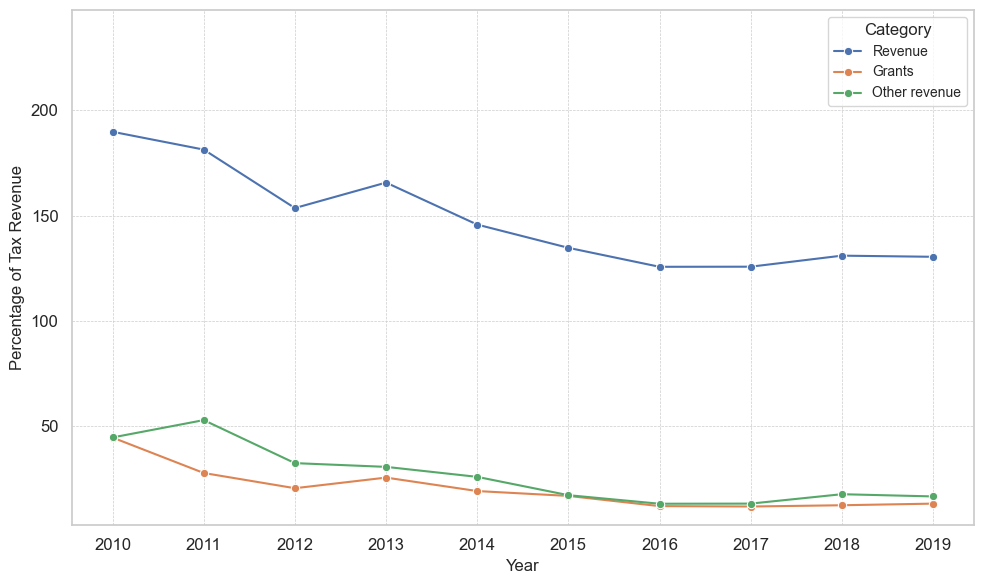

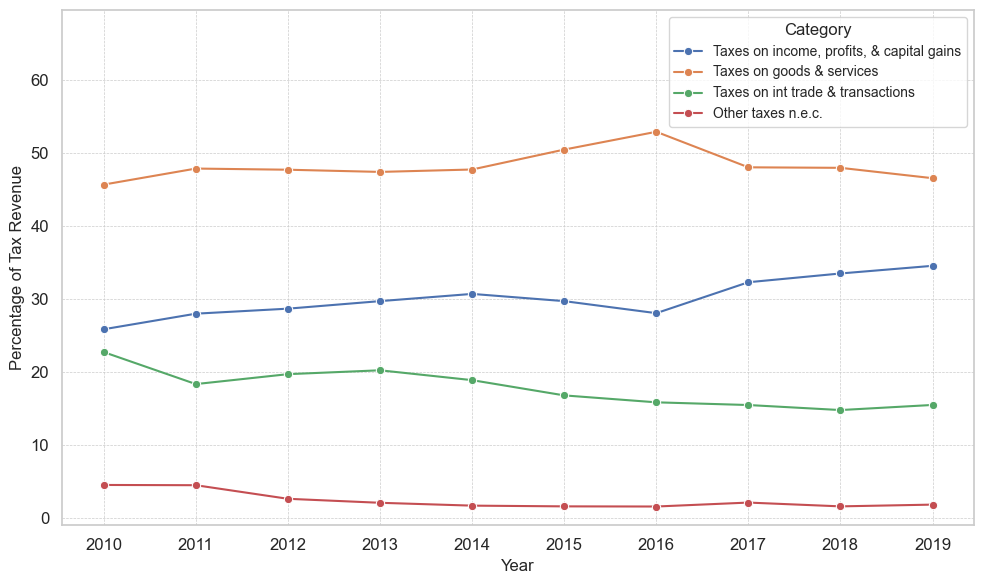

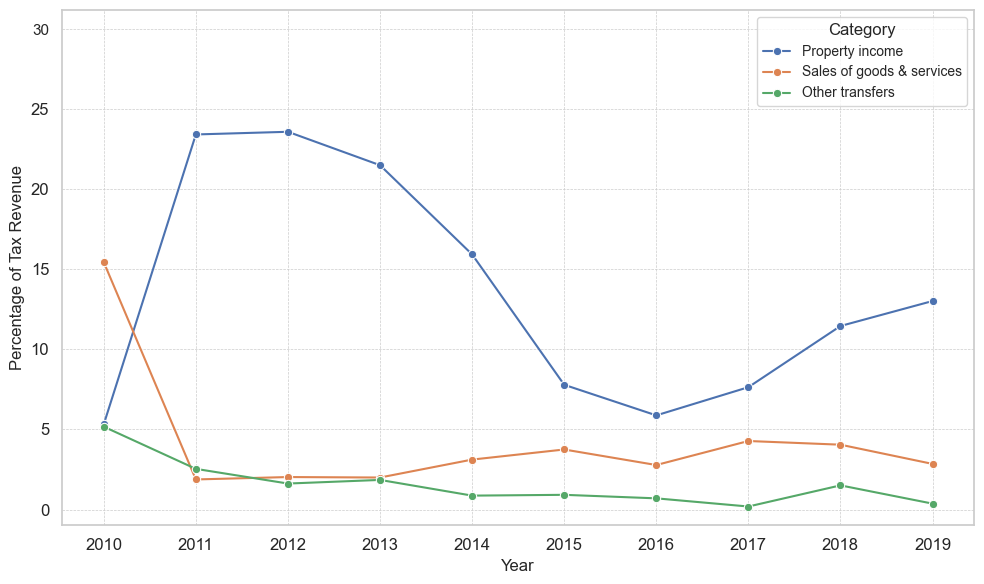

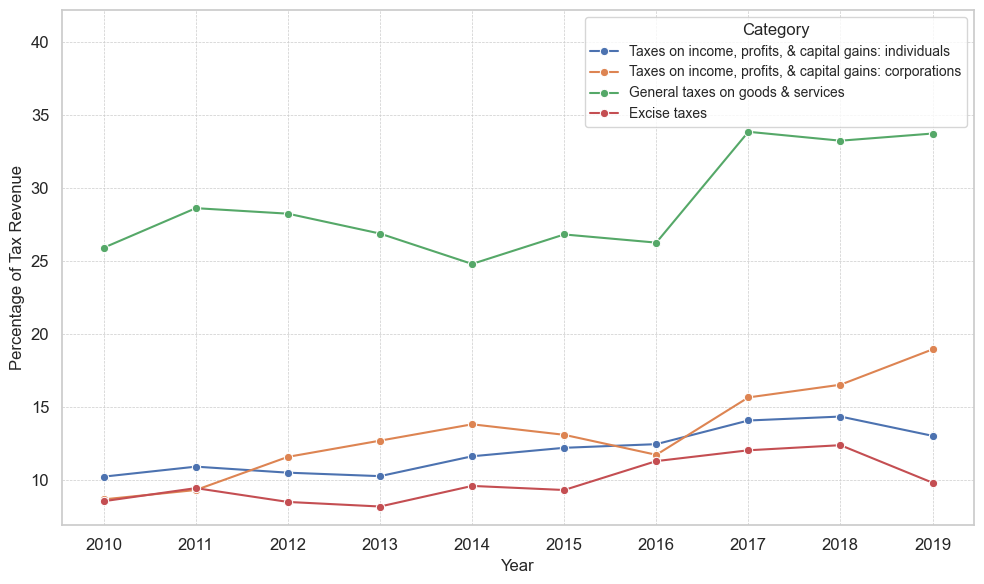

In [352]:
graph(['Revenue', 'Grants', 'Other revenue'])
graph(['Taxes on income, profits, & capital gains', 'Taxes on goods & services', 'Taxes on int trade & transactions', 'Other taxes n.e.c.'])
graph(['Property income', 'Sales of goods & services', 'Other transfers'])
graph(['Taxes on income, profits, & capital gains: individuals', 'Taxes on income, profits, & capital gains: corporations', 'General taxes on goods & services', 'Excise taxes'])